**《深度学习之 PyTorch 实战》**

讲师作者：[土豆老师](https://iphysresearch.github.io)

# 计算机视觉

近年来，深度学习一直是提高计算机视觉系统性能的变革力量。 无论是医疗诊断、自动驾驶车辆，还是智能滤镜、摄像头监控，许多计算机视觉领域的应用都与我们当前和未来的生活密切相关。 可以说，最先进的计算机视觉应用程序与深度学习几乎是不可分割的。 有鉴于此，本讲将重点介绍计算机视觉领域，并探讨最近在学术界和行业中具有影响力的方法和应用。


## 实战 Kaggle 比赛：狗的品种识别（ImageNet Dogs）

本节我们将在 Kaggle 上实战狗品种识别问题。 本次比赛的网址是 https://www.kaggle.com/c/dog-breed-identification。 下图显示了鉴定比赛网页上的信息。 你需要一个 Kaggle 账户才能提交结果。

在这场比赛中，我们将识别 120 类不同品种的狗。 这个数据集实际上是著名的 ImageNet 的数据集子集，却与上一节中 CIFAR-10 数据集中的图像不同。 ImageNet数据集中的图像更高更宽，且尺寸不一。

![](https://i.loli.net/2021/06/04/VXmpDW395AsboQc.png)

(狗的品种鉴定比赛网站，你可以通过单击“数据”选项卡来获得比赛数据集)

In [1]:
import os
import torch
import torchvision
from torch import nn
import dl4wm

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


### 获取和整理数据集

比赛数据集分为训练集和测试集，其中分别包含三个 RGB（彩色）通道的 10222 和 10357 张 JPEG 图像。 在训练数据集中，有 120 种犬类，如拉布拉多、贵宾、腊肠、萨摩耶、哈士奇、吉娃娃和约克夏等。


#### 下载数据集

登录 Kaggle 后，你可以点击上图中显示的竞争网页上的 “数据” 选项卡，然后点击 “全部下载” 按钮下载数据集。在 `./Datasets` 中解压下载的文件后，你将在以下路径中找到整个数据集：

- `./Datasets/dog-breed-identification/labels.csv`

- `./Datasets/dog-breed-identification/sample_submission.csv`

- `./数据/种身份识别/火车`

- `./数据/种身份识别/测试`

你可能已经注意到，上述结构与上一节的 CIFAR-10 竞争对手类似，其中文件夹 `train/` 和 `test/` 分别包含训练和测试狗图像，`labels.csv` 包含训练图像的标签。 同样，为了便于入门，我们提供了上面提到的数据集的一小部分示例：`train_valid_test_tiny.zip`。 如果你要在 Kaggle 比赛中使用完整的数据集，则需要将下面的 `demo` 变量更改为 `False`。

In [2]:
#@save
dl4wm.DATA_HUB['dog_tiny'] = (dl4wm.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# 如果你使用 Kaggle 比赛的完整数据集，请将下面的变量更改为 False
demo = False#True

if demo:
    data_dir = dl4wm.download_extract('dog_tiny')
else:
    data_dir = os.path.join('.', 'Datasets', 'dog-breed-identification')
    
# Downloading ./Datasets/kaggle_dog_tiny.zip from http://d2l-data.s3-accelerate.amazonaws.com/kaggle_dog_tiny.zip...

#### 整理数据集

我们可以像上一节中所做的那样整理数据集，即从原始训练集中拆分验证集，然后将图像移动到按标签分组的子文件夹中。

下面的 `reorg_dog_data` 函数读取训练数据标签、拆分验证集并整理训练集。

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = dl4wm.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    dl4wm.reorg_train_valid(data_dir, labels, valid_ratio)
    dl4wm.reorg_test(data_dir)

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

### 图像增广

回想一下，这个狗品种数据集是 ImageNet 数据集的子集，其图像大于上一节 中 CIFAR-10 数据集的图像。 下面我们看一下如何在相对较大的图像上使用图像增广。

In [4]:
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08到1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224 x 224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

测试时，我们只使用确定性的图像预处理操作。

In [5]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

###  读取数据集

与上一节一样，我们可以读取整理后的含原始图像文件的数据集。

In [6]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

下面我们创建数据加载器实例的方式与上节相同。

In [7]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

### 微调预训练模型

同样，本次比赛的数据集是 ImageNet 数据集的子集。 因此，我们可以使用上一节中讨论的方法在完整 ImageNet 数据集上选择预训练的模型，然后使用该模型提取图像要素，以便将其输入到定制的小规模输出网络中。 深度学习框架的高级 API 提供了在 ImageNet 数据集上预训练的各种模型。 在这里，我们选择预训练的 ResNet-34 模型，我们只需重复使用此模型的输出层（即提取的要素）的输入。 然后，我们可以用一个可以训练的小型自定义输出网络替换原始输出层，例如堆叠两个完全连接的图层。 与上一节中的实验不同，以下内容不重新训练用于特征提取的预训练模型，这节省了梯度下降的时间和内存空间。

回想一下，我们使用三个 RGB 通道的均值和标准差来对完整的 ImageNet 数据集进行图像标准化。 事实上，这也符合 ImageNet 上预训练模型的标准化操作。

In [8]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # 定义一个新的输出网络，共有120个输出类别
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(),
                                            nn.Linear(256, 120))
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    # 冻结参数
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

在计算损失之前，我们首先获取预训练模型的输出层的输入，即提取的特征。然后我们使用此特征作为我们小型自定义输出网络的输入来计算损失。

In [9]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum = l.sum()
        n += labels.numel()
    return l_sum / n

### 定义训练函数

我们将根据模型在验证集上的表显选择模型并调整超参数。模型训练函数 `train` 只迭代小型自定义输出网络的参数。

In [10]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD(
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), dl4wm.Timer()
    animator = dl4wm.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'valid loss'])
    for epoch in range(num_epochs):
        metric = dl4wm.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
        scheduler.step()
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f}, '
              f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

###  训练和验证模型

现在我们可以训练和验证模型了，以下超参数都是可调的。 例如，可以增加迭代周期：由于 `lr_period` 和 `lr_decay` 分别设置为 2 和 0.9，因此优化算法的学习速率将在每 2 个迭代后乘以 0.9。

train loss 0.918, valid loss 0.352
77.6 examples/sec on [device(type='cpu')]


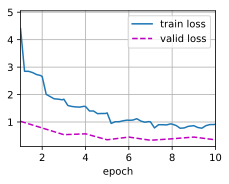

In [14]:
devices, num_epochs, lr, wd = dl4wm.try_all_gpus(), 10, 3e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


### 对测试集分类并在 Kaggle 提交结果

与上一节中的最后一步类似，最终所有标记的数据（包括验证集）都用于训练模型和对测试集进行分类。 我们将使用训练好的自定义输出网络进行分类。

train loss 0.839
41.4 examples/sec on [device(type='cpu')]


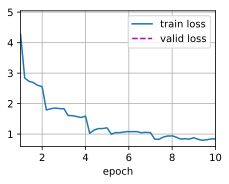

In [15]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(
    os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(
            i.split('.')[0] + ',' + ','.join([str(num)
                                              for num in output]) + '\n')

上面的代码将生成一个 `submission.csv` 文件，以「实战 Kaggle 比赛：预测房价」节中描述的方式提在 Kaggle 上提交。

### 小结

- ImageNet 数据集中的图像比 CIFAR-10 图像尺寸大，我们可能会修改不同数据集上任务的图像增广操作。

- 要对 ImageNet 数据集的子集进行分类，我们可以利用完整 ImageNet 数据集上的预训练模型来提取特征并仅训练小型自定义输出网络，这将减少计算时间和节省内存空间。